# CITS5508 Lab 5: Comparing Performance of MLP and CNN on CIFAR-10 Classification Task

Name: Joey Koh<br>
Student number: 21506379  
Date created: 6 May 2020  
Last modified: 20 May 2020  

This notebook compares the performance of a Multilayer Perceptron (MLP) and a Convolutional Neural Network (CNN) on classifying images in the CIFAR-10 dataset.<br>

Data: 32x32 pixel images, 60k total images.<br>

10 Classes (mutually exclusive): airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck <br>

Training set: 50k images split in random order into 5 training batches (10k images each). 5k images per class overall. Some batches may contain more images from one class than another.<br>

Test set: 1k randomly selected images from each class. 10k total.

Data structure:<br>
Each training/test batch file contains a dictionary with following elements.
- data: a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
- labels: a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

In "batches.meta", a python dictionary object with following entries:
- label_names : a 10-element list which gives meaningful names to the numeric labels in the labels array described above. For example, label_names[0] == "airplane", label_names[1] == "automobile", etc.
<br>

A MLP and a CNN are trained and judged in performance.

Database Citation:
Krizhevsky, A. and Hinton, G., 2009. Learning multiple layers of features from tiny images.

Todo:
- find for EDIT, REMOVE, ASK
- prevent global vars in Du's functions
- random states? #marcell dont spend too much time, EDIT. explain that values are random/ limitation of tf

## 1. Setup, Data Preparation
Import libraries to be used and bring the data in.<br>

In [0]:
import pandas as pd
import numpy as np
import sklearn as sk
import tensorflow as tf
from tensorflow import keras

#file tools
import os
import pickle

#Use jupyter's backend to render plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
#import matplotlib.lines as mlines
import seaborn as sns; sns.set(color_codes=True)
from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import mean_squared_error
import warnings;
#warnings.filterwarnings("ignore") #clear warnings

In [0]:
#For stopping the experimental code from being run, set to False
run_mlp_experiments = False
run_cnn_experiments = False

In [76]:
# IMPOTRTANT: set the path where the data files are relative to the Notebook file. 
# You can change the variable pathname below to anything that suits you, For example,
# if your Notebook file is to be run on Google Colab, then you will need to set up
# this variable properly, e.g., 
#       pathname = os.path.join('My Drive', 'CITS5508').

#REMOVE
from google.colab import drive
drive.mount('/content/gdrive') #already mounted, but need to remount if changing runtime
#print(os.listdir('.'))

#EDIT
# Before submitting your Notebook file to cssubmit, ensure that you change
# this variable back to '.'
#pathname = '.'
pathname = 'gdrive/My Drive/CITS5508'
#os.listdir('gdrive/My Drive/CITS5508') #lists directory, REMOVE


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#prepare a log directory for tensorboard visualisations if used
root_logdir = os.path.join(os.curdir, 'my_logs')

def get_run_logdir(): #get path based on root log directory and time
  import time
  run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S") #time string
  return os.path.join(root_logdir, run_id) #concat log dir path with time string id

run_logdir = get_run_logdir()

In [0]:
# function for loading the data_batch_file
def load_pickle_file(filename, path='.'):
    '''
    This function reads the given pickle file and returns a dictionary object.
    '''
    with open(os.path.join(path,filename), 'rb') as f:
        dict = pickle.load(f, encoding='bytes')
    return dict  


def load_training(filename_prefix, N_batches, path='.'):
    '''
    This function reads the 5 data batches and returns the X_train and y_train numpy arrays.
    To save memory space, X_train is set to 'float32' (single precision floating point number).
    If this causes an issue, it can be set to 'float64'. y_train is set to uint8. This is
    the same data type as the MNIST dataset, so it should be fine.
    '''
    batch_no = range(1,N_batches+1)  # the batch numbers start at 1
    # Read in the data_batch_ files
    batches = [load_pickle_file(filename_prefix+str(b), path=path) for b in batch_no]

    # variable batches is a list containing 5 elements, each of which is a dictionary object

    # compose our X_train and y_train
    # according to the download site, the training set should have 50,000 instances. We caldulate
    # the length from the dictionary that we read in anyway.
    batch_sizes = [len(batches[i][b'labels']) for i in range(N_batches)]
    train_set_size = np.sum(batch_sizes)

    X_train = np.zeros((train_set_size, width, height, Nchannels), dtype='float32')
    y_train = np.zeros(train_set_size).astype('uint8')
    loc = 0
    for i in range(N_batches):
        X_train[loc:(loc+batch_sizes[i]),:,:,:] = np.rollaxis( #for data structure orientation
            np.reshape(batches[i][b'data'], (-1,Nchannels,height,width)), 1, 4) / 255.0 #normalise pixel values to range 0..1
        y_train[loc:(loc+batch_sizes[i])] = batches[i][b'labels']
        loc += batch_sizes[i]
    return X_train, y_train


def load_testing(filename, path='.'):
    '''
    This function reads the test_batch and returns X_test and y_test.
    To save memory space, X_test is set to 'float32' (single precision floating point number).
    If this causes an issue, it can be set to 'float64'. y_test is set to uint8. This is
    the same data type as the MNIST dataset, so it should be fine.
    '''
    # now read test_batch and construct the test set
    test_dict = load_pickle_file(filename, path=path)
    
    X_test = np.rollaxis(np.reshape(test_dict[b'data'], (-1,Nchannels,height,width)), 1, 4) / 255.0
    #X_test = np.swapaxes(np.swapaxes(
    #    np.reshape(test_dict[b'data'], (-1,Nchannels,width,height)), 1, 3), 1, 2) / 255.0 #normalise pixel values to range 0..1
    X_test = X_test.astype('float32')
    y_test = np.array(test_dict[b'labels'], dtype='uint8')
    return X_test, y_test

In [79]:
# According to the download site, the training set is split into five batches stored in 5 files,
# each colour image has dimension equal to 32 x 32 x 3, and there are 10 classes.
width, height, Nchannels = 32, 32, 3 #3 for RGB values per pixel
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

N_batches = 5  
train_filename_prefix = 'data_batch_'
test_filename = 'test_batch'
#Load data sets
train_X, train_y = load_training(train_filename_prefix, N_batches, path=pathname)
test_X, test_y = load_testing(test_filename, path=pathname)
#Quick check that all data is loaded
print('Number of training instances:', train_X.shape[0])
print('Number of test instances:    ', test_X.shape[0])

Number of training instances: 50000
Number of test instances:     10000


## 2. Multilayer Perceptron (MLP)
We design a fully connected MLP with two hidden layers and 10 epochs. We tune some hyperparameters by first comparing 8 variations of the model with different settings to select the optimal settings.

### 2.1 Setting Experiments

#### Hyperparameter Tuning Process
We consider 3 hyperparameters with 2 suitable settings each. From this, we obtain 8 variations of the MLP model. We train these on a subset of training data with a validation set split by ratio. Then, we observe the learning curves of our experiments to look out for overfitting particularly, and determine which model produces the best validation accuracy.

The 3 hyperparameters tuned are:
- Connection Weight Initialisation (CWI): We initialise the connection weights to deal with the vanishing/exploding gradient problem. This occurs mainly due to variance of layer outputs being significantly greater than the variance of its inputs, and the saturation of the logistic sigmoid activation function producing a negligible derivative during large magnitude inputs. The resulting gradients decrease/increase drastically as the algorithm reaches lower layers and we have a poor or slow convergence to a good solution.

> We require the signal to not die out or explode and saturate. The signal must flow properaly in both directions – forward for predictions and backwards for backpropogation. Ideally, the layer's input/output variances must be equal, and the variance of gradients must be equal before/after passing through a layer. By initializing the connection weights randomly, it helps prevent vanishing/exploding gradients.

> As different weight initialization strategies suit different activation functions better, we explore two different initialization strategies and the activation functions they are usually used with.

> 1. CWI1: Normal He initialization with ReLU activation function. 
  >> He initialization with a normal distribution has a variance of ```2/fan in``` with a mean of 0. It is suited for ReLU functions and its variants. The ReLU (rectified linear unit) activation function is optimised for speed and also does not saturate for positive values.

 >2. CWI2: Normal LeCun initilization with SELU activation function.
  >> LeCun initilization with a normal distribution has a variance of ```1/fan avg``` with a mean of 0. It is suited for the SELU activation function. The Scaled ReLU (SELU) activation function has a self-normalising property which allows it to better preserve the variance and mean of layer outputs during training.

>> (fan in being number of layer input units, and fan avg being the average of input/output layer units)<br>

- Learning Rate Scheduling (LRS): High learning rates cause divergence while low learning rates make the convergence to a good solution take a long time. Learning rate scheduling generally takes advantage of having a relatively high initial learning rate to converge faster, and slowing it down once the progress drops to prevent divergence. With the limited epochs for this model, learning rate scheduling allows us to reduce training time and also converge to a better solution than a constant learning rate would.

  1. LRS1: Performance Scheduling.
  > This method measures the validation error every N steps, before reducing the learning rate by a factor when error fails to reduce. I.e. we reduce learning rate when performance of training at current learning rate yields less in reducing error.
  2. LRS2: Power Scheduling.
  > Based on iteration step number, we set a decay rate in the below equation. Thus, every set number of steps the initial learning rate decays.
  ```lr = lr0 / (1 + steps / s)**c```<br>
  Keras uses `c=1` and `s = 1 / decay`

- Early Stopping: This regularisation technique helps **prevent overfitting** on the training data. We aim to stop training once the validation error reaches a minimum. However, given the small number of epochs allowed and from experimenting, it was found that early stopping is less viable in improving the model as we tend to observe improvements on validation accuracy even in the last few epochs. We monitor the val_loss as we are trying to prevent overfitting on training set, thus we are based on improvement towards validation set. For early stopping, we explore different settings for minimum improvement in val_loss required to continue training and the patience in number of epochs before halting.<br>

  1. ES1: no min_delta and patience of 3 to force early stopping.
  2. ES2: min_delta improvement of 0.02 and patience of 2 to force early stopping.

**From these, we produce 8 variations to train and compare performance on a validation set**<br>
MLP Model number:
1. CW1, LRS1, ES1
2. CW2, LRS1, ES1
3. CW1, LRS2, ES1
4. CW2, LRS2, ES1
5. CW1, LRS1, ES2
6. CW2, LRS1, ES2
7. CW1, LRS2, ES2
8. CW2, LRS2, ES2

In [0]:
#Set common parameters
#For layers
width, height, Nchannels = 32, 32, 3 #32x32 pixels per image, with 3 for RGB values per pixel
neurons_hidden_1, neurons_hidden_2, neurons_output = 100, 100, 10 #number of neurons
val_ratio = 0.1 #for validation set split

#For Connection Weight initialisation
cwi1_activation_hidden, cwi2_activation_hidden = "relu", "selu" #activation function in hidden layers
cwi1_weight_init, cwi2_weight_init = "he_normal", "lecun_normal" #strategy to randomly initilize connection weights at each layer

#For Learning Rate scheduling
lrs1_cb = keras.callbacks.ReduceLROnPlateau(factor= 0.5, monitor= 'val_loss', patience= 2, min_delta= 0.01) #performance scheduling and early stopping, monitor what? #ASK val_loss or loss? i think loss as val_loss changes slowly initially
lr_mlp = 0.01 #constant to ensure learning rate is set everytime function is called
#lrs1_optimizer = keras.optimizers.Adam(lr= lr_mlp, beta_1= 0.9, beta_2= 0.999)
#lrs2_optimizer = keras.optimizers.Adam(lr= lr_mlp, beta_1= 0.9, beta_2= 0.999, decay= 1e-4) #power scheduling
lrs1_optimizer = keras.optimizers.SGD(lr= lr_mlp)
lrs2_optimizer = keras.optimizers.SGD(lr= lr_mlp, decay= 1e-4) #power scheduling

#For Early Stopping
es1_cb = keras.callbacks.EarlyStopping(monitor= 'val_loss', patience= 3, restore_best_weights= True)
es2_cb = keras.callbacks.EarlyStopping(monitor= 'val_loss', patience= 2, min_delta= 0.05, restore_best_weights= True)

#Function for training MLP model variations
def mlp_train_model(model_name, cwi_activation, cwi_weight_init, lrs_optimizer, es_cb, lrs_cb = None, tensorboard_cb = None):
  print("\nTraining: ", model_name)
  model_mlp = keras.models.Sequential([
                                  keras.layers.Flatten(input_shape=[width,height,Nchannels]), #input layer 
                                  keras.layers.Dense(neurons_hidden_1, activation= cwi_activation, kernel_initializer= cwi_weight_init), #hidden layer 1
                                  keras.layers.Dense(neurons_hidden_2, activation= cwi_activation, kernel_initializer= cwi_weight_init), #hidden layer 2
                                  keras.layers.Dense(neurons_output, activation = "softmax") #output layer
  ])
  #Compile and train model
  model_mlp.compile(loss= "sparse_categorical_crossentropy", optimizer= lrs_optimizer, metrics=["accuracy"])
  if lrs_cb == None:
    hist = model_mlp.fit(train_X, train_y, epochs= 10, validation_split = val_ratio, callbacks= [es_cb])
  else:
    hist = model_mlp.fit(train_X, train_y, epochs= 10, validation_split = val_ratio, callbacks= [lrs_cb, es_cb])

  #Reset optimizers for next use, to ensure learning rate is reset
  #lrs1_optimizer = keras.optimizers.Adam(lr= lr_mlp, beta_1= 0.9, beta_2= 0.999)
  #lrs2_optimizer = keras.optimizers.Adam(lr= lr_mlp, beta_1= 0.9, beta_2= 0.999, decay= 1e-4)
  lrs1_optimizer = keras.optimizers.SGD(lr= lr_mlp)
  lrs2_optimizer = keras.optimizers.SGD(lr= lr_mlp, decay= 1e-4) #power scheduling
  return hist, model_mlp, lrs1_optimizer, lrs2_optimizer #return the History object and model trained


#### Optimiser and Loss Function
- Optimiser: SGD (Stochastic Gradient Descent) Optimiser was used. While other optimisers might be faster to converge and/or adaptive. We are not tuning the optimiser used, and adaptive learning rate algorithms would interfere/diminish the impact of the learning rate scheduling settings explored.
- Loss function: sparse_catgeorical_crossentropy loss function used as this is a multi-class classification problem with integers representing each category (not 1-hot encoded)


In [81]:
if run_mlp_experiments == True:
  #Call training function for each model to get history objects and trained models
  history_mlp_1, model_mlp_1, lrs1_optimizer, lrs2_optimizer = mlp_train_model("model_mlp_1", cwi1_activation_hidden, cwi1_weight_init, lrs1_optimizer, es1_cb, lrs_cb = lrs1_cb)
  history_mlp_2, model_mlp_2, lrs1_optimizer, lrs2_optimizer = mlp_train_model("model_mlp_2", cwi2_activation_hidden, cwi2_weight_init, lrs1_optimizer, es1_cb, lrs_cb = lrs1_cb)
  history_mlp_3, model_mlp_3, lrs1_optimizer, lrs2_optimizer = mlp_train_model("model_mlp_3", cwi1_activation_hidden, cwi1_weight_init, lrs2_optimizer, es1_cb)
  history_mlp_4, model_mlp_4, lrs1_optimizer, lrs2_optimizer = mlp_train_model("model_mlp_4", cwi2_activation_hidden, cwi2_weight_init, lrs2_optimizer, es1_cb)
  history_mlp_5, model_mlp_5, lrs1_optimizer, lrs2_optimizer = mlp_train_model("model_mlp_5", cwi1_activation_hidden, cwi1_weight_init, lrs1_optimizer, es2_cb, lrs_cb = lrs1_cb)
  history_mlp_6, model_mlp_6, lrs1_optimizer, lrs2_optimizer = mlp_train_model("model_mlp_6", cwi2_activation_hidden, cwi2_weight_init, lrs1_optimizer, es2_cb, lrs_cb = lrs1_cb)
  history_mlp_7, model_mlp_7, lrs1_optimizer, lrs2_optimizer = mlp_train_model("model_mlp_7", cwi1_activation_hidden, cwi1_weight_init, lrs2_optimizer, es2_cb)
  history_mlp_8, model_mlp_8, lrs1_optimizer, lrs2_optimizer = mlp_train_model("model_mlp_8", cwi2_activation_hidden, cwi2_weight_init, lrs2_optimizer, es2_cb)

else:
  continue


Training:  model_mlp_1
Epoch 1/10
1407/1407 [==============================] - 3s 2ms/step - loss: 1.9126 - accuracy: 0.3096 - val_loss: 1.9946 - val_accuracy: 0.2740 - lr: 0.0100
Epoch 2/10
1407/1407 [==============================] - 3s 2ms/step - loss: 1.7316 - accuracy: 0.3818 - val_loss: 1.7873 - val_accuracy: 0.3456 - lr: 0.0100
Epoch 3/10
1407/1407 [==============================] - 3s 2ms/step - loss: 1.6541 - accuracy: 0.4109 - val_loss: 1.8026 - val_accuracy: 0.3708 - lr: 0.0100
Epoch 4/10
1407/1407 [==============================] - 3s 2ms/step - loss: 1.5998 - accuracy: 0.4285 - val_loss: 1.6347 - val_accuracy: 0.4190 - lr: 0.0100
Epoch 5/10
1407/1407 [==============================] - 3s 2ms/step - loss: 1.5606 - accuracy: 0.4464 - val_loss: 1.6728 - val_accuracy: 0.4000 - lr: 0.0100
Epoch 6/10
1407/1407 [==============================] - 3s 2ms/step - loss: 1.5270 - accuracy: 0.4564 - val_loss: 1.5665 - val_accuracy: 0.4380 - lr: 0.0100
Epoch 7/10
1407/1407 [============

Learning curves for 8 MLP model experiments

Learning curve 1


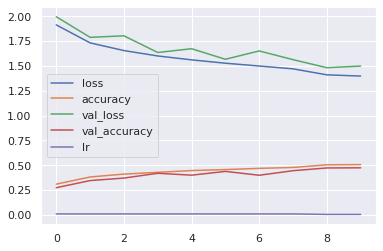


Learning curve 2


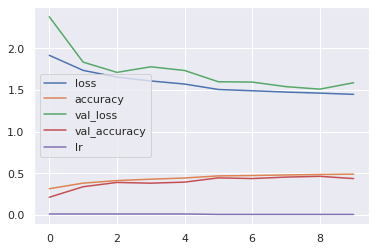


Learning curve 3


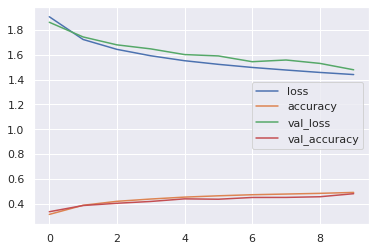


Learning curve 4


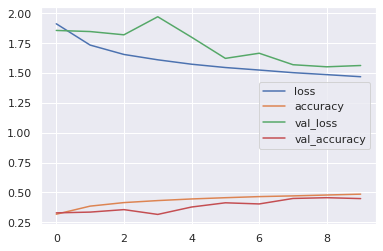


Learning curve 5


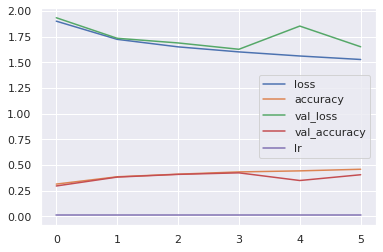


Learning curve 6


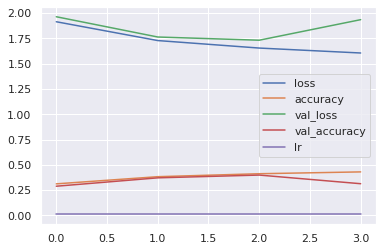


Learning curve 7


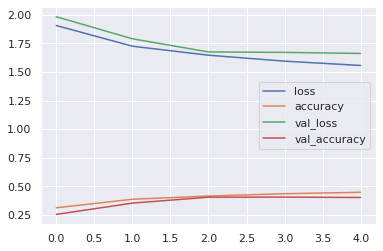


Learning curve 8


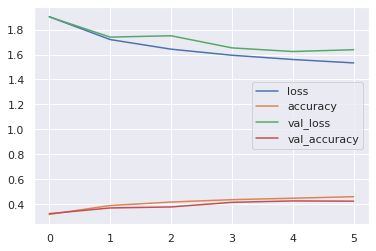

'\npd.DataFrame(history_1.history).plot(figsize=(8, 10))\nplt.grid(True)\nplt.gca().set_ylim(0, 3) # set the vertical range\nplt.show()\n\npd.DataFrame(history_2.history).plot(figsize=(8, 10))\nplt.grid(True)\nplt.show()\n\nprint(\'Learning curves for 8 MLP model experiments\')\nplt.figure(figsize=(10, 8))\nfor i in range(8):\n  learning_curves(hist)\n  ax = plt.subplot(4,2,i+1)\n  ax.set_title("Model ", i)\n\nplt.show()\n\n\nwhile i < 20:\n  if test_y[n] != test_y_pred[n]:\n    ax = plt.subplot(4,5,i+1)\n    plt.imshow(test_X[n])\n    plt.axis(\'off\')\n    ax.set_title(class_names[test_y[n]] +", "+ class_names[test_y_pred[n]])\n    i = i +1\n    n = n +1 \n  else:\n    n = n +1\n\nplt.show()\n\n'

In [83]:
fig_size = (6,4)
def learning_curves(hist, numb, default= fig_size): #learning curve plot function
  print("\nLearning curve",numb)
  pd.DataFrame(hist.history).plot(figsize= fig_size)
  plt.grid(True)
  plt.show()

if run_mlp_experiments == True:
  #Plot learning curves
  print('Learning curves for 8 MLP model experiments')
  learning_curves(history_mlp_1,"1")
  learning_curves(history_mlp_2,"2")
  learning_curves(history_mlp_3,"3")
  learning_curves(history_mlp_4,"4")
  learning_curves(history_mlp_5,"5")
  learning_curves(history_mlp_6,"6")
  learning_curves(history_mlp_7,"7")
  learning_curves(history_mlp_8,"8")
else:
  continue

In [84]:
if run_mlp_experiments == True:
  print("model_mlp_1 validation accuracy = ", round(history_mlp_1.history['val_accuracy'][-1],3))
  print("model_mlp_2 validation accuracy = ", round(history_mlp_2.history['val_accuracy'][-1],3))
  print("model_mlp_3 validation accuracy = ", round(history_mlp_3.history['val_accuracy'][-1],3))
  print("model_mlp_4 validation accuracy = ", round(history_mlp_4.history['val_accuracy'][-1],3))
  print("model_mlp_5 validation accuracy = ", round(history_mlp_5.history['val_accuracy'][-1],3))
  print("model_mlp_6 validation accuracy = ", round(history_mlp_6.history['val_accuracy'][-1],3))
  print("model_mlp_7 validation accuracy = ", round(history_mlp_7.history['val_accuracy'][-1],3))
  print("model_mlp_8 validation accuracy = ", round(history_mlp_8.history['val_accuracy'][-1],3))
else:
  continue

model_mlp_1 validation accuracy =  0.474
model_mlp_2 validation accuracy =  0.436
model_mlp_3 validation accuracy =  0.479
model_mlp_4 validation accuracy =  0.448
model_mlp_5 validation accuracy =  0.406
model_mlp_6 validation accuracy =  0.313
model_mlp_7 validation accuracy =  0.401
model_mlp_8 validation accuracy =  0.425


#### Experiment Findings
MLP Model number:
1. CW1, LRS1, ES1
2. CW2, LRS1, ES1
3. CW1, LRS2, ES1
4. CW2, LRS2, ES1
5. CW1, LRS1, ES2
6. CW2, LRS1, ES2
7. CW1, LRS2, ES2
8. CW2, LRS2, ES2
```
model_mlp_1 validation accuracy =  0.474
model_mlp_2 validation accuracy =  0.436
model_mlp_3 validation accuracy =  0.479
model_mlp_4 validation accuracy =  0.448
model_mlp_5 validation accuracy =  0.406
model_mlp_6 validation accuracy =  0.313
model_mlp_7 validation accuracy =  0.401
model_mlp_8 validation accuracy =  0.425
```
From these output final validation accuracies of the 8 MLP variations, we observe that model_mlp_8 produces the highest accuracy of 0.49<br>
Thus, **model 8 has the optimum hyperparameter settings** from our experiments.

- Connection Weight Initialisation (CWI): 
  1. CWI1: Normal He initialization with ReLU activation function. 
  2. CWI2: Normal LeCun initilization with SELU activation function.
> The He initialisation with normal distribution and ReLU activation function performed better than the LeCun with SELU. It is likely due to the ReLU function's better compatibility with the SGD optimiser used.

- Learning Rate Scheduling (LRS): 
  1. LRS1: Performance Scheduling.
  2. LRS2: Power Scheduling.
> Power scheduling worked better in this case oddly enough. Having a consistent decay was better than basing on the validation loss. 

- Early Stopping:
  1. ES1: no min_delta and patience of 3 to force early stopping.
  2. ES2: min_delta improvement of 0.02 and patience of 2 to force early stopping.
> Having no early stopping from ES1 was better than forcing an early stopping with ES2 consistently. This is due to the model still not converging to a good solution in early stopping within 10 epochs (which is already a low number).


### 2.2 Optimal Settings
Using optimal parameters from experiments<br>
The highest accuracy on the validation set was achieved with model 8, which is CW2, LRS2, ES2

In [86]:
#Training MLP optimal model
history_mlp, model_mlp, lrs1_optimizer, lrs2_optimizer = mlp_train_model("model_8", cwi2_activation_hidden, cwi2_weight_init, lrs2_optimizer, es2_cb, lrs_cb = None)


Training:  model_8
Epoch 1/10
1407/1407 [==============================] - 3s 2ms/step - loss: 1.9145 - accuracy: 0.3136 - val_loss: 1.8687 - val_accuracy: 0.3188
Epoch 2/10
1407/1407 [==============================] - 3s 2ms/step - loss: 1.7313 - accuracy: 0.3852 - val_loss: 1.7385 - val_accuracy: 0.3996
Epoch 3/10
1407/1407 [==============================] - 3s 2ms/step - loss: 1.6517 - accuracy: 0.4155 - val_loss: 1.8033 - val_accuracy: 0.3532
Epoch 4/10
1407/1407 [==============================] - 3s 2ms/step - loss: 1.6027 - accuracy: 0.4349 - val_loss: 1.7325 - val_accuracy: 0.3900


In [87]:
#Inspect model architecture 
model_mlp.summary() 

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_69 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_207 (Dense)            (None, 100)               307300    
_________________________________________________________________
dense_208 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_209 (Dense)            (None, 10)                1010      
Total params: 318,410
Trainable params: 318,410
Non-trainable params: 0
_________________________________________________________________


#### MLP Network Architecture
**Layer Settings**
- Input layer: Each input image consists of 32x32 pixels with each pixel represented by 3 RGB values. As the first input layer disregards the pixels' positions, we need to flatten the image into a 1D vector to obtain the number of input neurons required and to feed it in.
> The input layer flattens the image, giving an output of 32x32x3 = 3072

- 2 Hidden layers: Same no. of neurons used for both layers to reduce no. of parameters to tune. Similar performance to pyramid shape configuration.
> First dense hidden layer: It consists of 100 fully connected neurons, so the number of parameters is 3072(inputs) x100(layer neurons) +100 (for bias neurons) = 307300. The number of outputs equals the number of layer neurons of 100.<br>
> Second dense hidden layer: It consists of 100 fully connected neurons, so the number of parameters is 100(inputs) x100(layer neurons) +100 (for bias neurons) = 10100. The number of outputs also is 100.

- Output layer: 10 neurons for the 10 possible classes. Softmax activation function used as this is a multiclass problem with mutually exclusive classes. This ensures outputs are probabilities that sum to 1.
> Output dense layer: With 10 output neurons for the 10 classes the number of parameters is 100(inputs) x10(layer neurons) +10 (for bias neurons) = 1010.<br>

Observe:
- The number of parameters reduce each layer. This is good as we want the network to narrow in some form as we get closer to the final output layer.

#### 2.2.1 Confusion Matrix and Accuracy

In [0]:
from matplotlib.ticker import MultipleLocator #for force labelling plot ticks

#Function to generate confusion matrix
def conf_matrix(actual_y, pred_y, model):
    #confusion matrix generation
    class_pred_y = np.array(class_names)[pred_y] #get predicted class names
    class_actual_y = np.array(class_names)[actual_y]

    conf_mx = confusion_matrix(class_actual_y, class_pred_y, class_names)
    print("This is the confusion matrix for",model,"\n",conf_mx)

    #visualisation setup
    alpha = class_names
    conf_data = conf_mx

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_data, interpolation='nearest')
    fig.colorbar(cax) #adds colour bar to figure
    #axis settings
    ax.xaxis.set_major_locator(MultipleLocator(1)) #force label every cell
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.set_xticklabels(['']+alpha) #add tick labels from alpha (classnames)
    ax.set_yticklabels(['']+alpha)
    plt.setp(ax.get_xticklabels(), rotation=90) #orient x-axis labels

    plt.show
    print("Plotting with predicted test dataset labels on horizontal axis, actuals labels on vertical axis")

This is the confusion matrix for MLP 
 [[420  31  77   2  32   1  17  95 264  61]
 [ 53 420  27  12  35   4  25  80 153 191]
 [ 85  30 338  27 207  10  63 157  59  24]
 [ 45  35 141 148 137  53  83 185  86  87]
 [ 43  21 187  17 404   3  79 167  48  31]
 [ 26  28 133  81 147 145  69 224 108  39]
 [ 16  33 151  33 207  13 358 116  24  49]
 [ 32  22  56  14 113   9  23 609  54  68]
 [ 72  53  19   6  24   4   3  42 691  86]
 [ 44 124  17  12  20   5  31  86 154 507]]
Plotting with predicted test dataset labels on horizontal axis, actuals labels on vertical axis


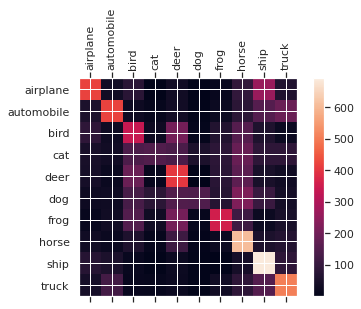

In [89]:
test_y_mlp_pred = np.argmax(model_mlp.predict(test_X), axis=-1) #get predicted class index numbers
#call confusion matrix function
conf_matrix(test_y, test_y_mlp_pred, "MLP")


Learning curve Final MLP


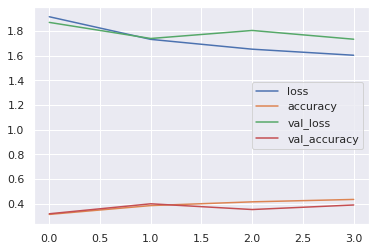

Evaluating MLP model on test set
313/313 [==============================] - 1s 2ms/step - loss: 1.7146 - accuracy: 0.4040


[1.7146461009979248, 0.40400001406669617]

In [91]:
#plot learning curve
learning_curves(history_mlp, "Final MLP")
#Evaluate model accuracy on test set
print("Evaluating MLP model on test set")
model_mlp.evaluate(test_X,test_y) #occurs in batches

### Classification Results of tuned MLP model

Accuracy score on test set: The tuned MLP model obtained a 0.489 accuracy on the test set classification task. Considering a random guess would be 0.1, this result is better than nothing. <br>

Confusion matrix observations: 
- Generally, we have values concentrated on the diagonal. Indicating correct predictions.
- However, we notice some visible non-dark squares outside the diagonal. These incorrect predictions have some noticable patterns in that their images have similar features (eyes, shape, object structure, wheels...etc).
- For vehicles: the following incorrect predictions are common (actual, predicted): (airplane, ship), (truck, automobile), (automobile, ship). Perhaps it is due to airplanes/ships having similar streamlined outlines and colour, truck/automobiles being wheeled vehicles, automobile/ships having windows.
- For animals: bird, cat, deer, dog, frog, horse have many dim squares outside the diagonal indicating incorrect predictions. It is likely due to the common features of legs, eyes, colour, outline. In particular, the cats are often incorrectly classified as dogs. <br>

**Explanation:**
The somewhat unimpressive performance in accuracy is due a few reasons.
- **Constrictions in network architecture** with a limit of 2 hidden layers. MLPs can theoretically model complex problems with a single layer given enough neurons. However, for complex problems like image classification here, deep networks with more layers have a higher parameter efficiency than shallow ones. MLPs are fully connected and aim to model low-level structures in lower hidden layers, continuously building up to higher-level structures in higher layers. When we only have two layers instead of say 5, we have reduced parameter efficiency and lack intermediate layers for intermediate-level structure modelling. We essentially are forced to jump ahead.
- **Low number of epochs**, 10. By restricting the number of passes through the training set, we essentially are implementing early stopping on epoch number 10 regardless of improvement to accuracy or loss function. A better practice is to simply implement early stopping instead and not limit the number of epochs. We observe that the model still has accuracy improvements in the 10th epoch, by stopping the training there, the accuracy cannot improve further even if the model has not converged to a good solution.<br>

**Hyperparameters tuned** This model had the optimum settings found through experiments. However, exploring more hyperparameter settings would likely yield a more optimised model. For example, trying out more activation functions or increasing the number of neurons in a layer.


#### 2.2.2 Correct and Wrong Predictions

The first 20 correctly classified images of the test set


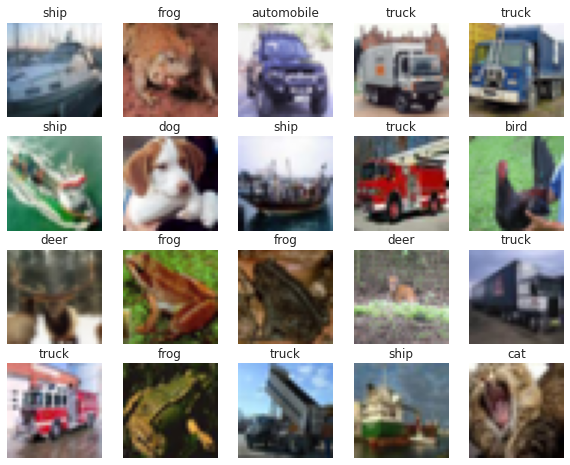

The first 20 incorrectly classified images of the test set. 
 Titles are actual class, predicted class respectively


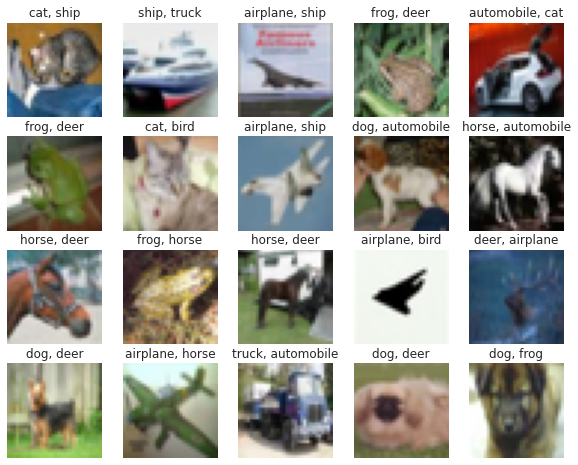

In [92]:
# display 20 correct predictions in the test set
print('The first 20 correctly classified images of the test set')
plt.figure(figsize=(10, 8))
i, n = 0, 0
while i < 20:
  if test_y[n] == test_y_mlp_pred[n]:
    ax = plt.subplot(4,5,i+1)
    plt.imshow(test_X[n])
    plt.axis('off')
    ax.set_title(class_names[test_y[n]])
    i = i +1
    n = n +1 
  else:
    n = n +1

plt.show()

# display 20 incorrect predictions in the test set
print('The first 20 incorrectly classified images of the test set. \n Titles are actual class, predicted class respectively')
plt.figure(figsize=(10, 8))
i, n = 0, 0
while i < 20:
  if test_y[n] != test_y_mlp_pred[n]:
    ax = plt.subplot(4,5,i+1)
    plt.imshow(test_X[n])
    plt.axis('off')
    ax.set_title(class_names[test_y[n]] +", "+ class_names[test_y_mlp_pred[n]])
    i = i +1
    n = n +1 
  else:
    n = n +1

plt.show()

**Observations**:
- For correctly classified images, we notice that the model is good at classifying dogs and frogs well, this aligns with our confusion matrix.
- For incorrectly classified images, we notice that the model fails to generalise as well when the images are more open to interpretation. For example the airplane in bottom row could look like a bird, the frog in third row has a similar side-outline to a horse, the airplane in second row looks like a ship surrounded by blue water...etc. This aligns with our conclusions from our confusion matrix.

## 3. Convolutional Neural Network (CNN)

### 3.1 Setting Experiments

#### Hyperparameter Tuning Process
We consider 4 hyperparameters with 2 suitable settings each. From this, we obtain 16 variations of the CNN model. We train these on a subset of training data with a validation set split by ratio. Then, we observe the learning curves of our experiments to look out for overfitting particularly, and also determine which model produces the best validation accuracy.



>> (fan in being number of layer input units, and fan avg being the average of input/output layer units)<br>

- **Connection Weight Initialisation (CWI)**: We initialise the connection weights to deal with the vanishing/exploding gradient problem. This occurs mainly due to variance of layer outputs being significantly greater than the variance of its inputs, and the saturation of the logistic sigmoid activation function producing a negligible derivative during large magnitude inputs. The resulting gradients decrease/increase drastically as the algorithm reaches lower layers and we have a poor or slow convergence to a good solution.

> We require the signal to not die out or explode and saturate. The signal must flow properaly in both directions – forward for predictions and backwards for backpropogation. Ideally, the layer's input/output variances must be equal, and the variance of gradients must be equal before/after passing through a layer. By initializing the connection weights randomly, it helps prevent vanishing/exploding gradients.

> As different weight initialization strategies suit different activation functions better, we explore two different initialization strategies and the activation functions they are usually used with.

Other hyperparameters set:
- **Padding:** "VALID" is used as for these images, the feature importance of boundary pixels are negligible. Thus, we can simply ignore them with no padding and speed up computation time as well.

**From these, we produce 16 variations to train and compare performance on a validation set**<br>
CNN Model number:
1. ks1, nof1, dr1, af1
2. ks1, nof1, dr1, af2
3. ks1, nof1, dr2, af1
4. ks1, nof1, dr2, af2
5. ks1, nof2, dr1, af1
6. ks1, nof2, dr1, af2
7. ks1, nof2, dr2, af1
8. ks1, nof2, dr2, af2
9. ks2, nof1, dr1, af1
10. ks2, nof1, dr1, af2
11. ks2, nof1, dr2, af1
12. ks2, nof1, dr2, af2
13. ks2, nof2, dr1, af1
14. ks2, nof2, dr1, af2
15. ks2, nof2, dr2, af1
16. ks2, nof2, dr2, af2

In [0]:
  #Set common parameters
##For layers
width, height, Nchannels = 32, 32, 3 #32x32 pixels per image, with 3 for RGB values per pixel
neurons_hidden_1, neurons_hidden_2, neurons_output = 100, 100, 10 #number of neurons
val_ratio = 0.1 #for validation set split

#For convolutional layers
padding = "VALID"
pooling_size = 2

#For Kernel Size
ks1, ks2 = (5,3,2), (3,3,1) #last value is stride for first layer

#For Number of Filters
nof1, nof2 = 64, 128

#For Dropout rate
dr1, dr2 = 0.1, 0.3

#For Activation Function, tuples of activation function and connection weight initialisation strategy
af1, af2 = ("relu","he_normal"),("selu","lecun_normal")

#For Learning Rate scheduling
lrs1_cb = keras.callbacks.ReduceLROnPlateau(factor= 0.5, monitor= 'val_loss', patience= 2, min_delta= 0.1) #performance scheduling and early stopping, monitor what? #ASK val_loss or loss? i think loss as val_loss changes slowly initially
lr_cnn = 0.001 #constant to ensure learning rate is set everytime function is called
#lrs1_optimizer = keras.optimizers.SGD(lr= lr_mlp)
#lrs2_optimizer= keras.optimizers.SGD(lr= lr_mlp, decay= 1e-4) #power scheduling
#cnn_optimizer= keras.optimizers.Adam(lr= lr_cnn, beta_1= 0.9, beta_2= 0.999) #edit
cnn_optimizer= keras.optimizers.SGD(lr= 0.01)

#Function for training CNN model variations
def cnn_train_model(model_name, kernel_size, numb_filters, drop_rate, activation_and_weight_init, cnn_optimizer, es_cb= None, lrs_cb = None):
    print("\nTraining: ", model_name)
    model_cnn = keras.models.Sequential([
                                        keras.layers.Conv2D(filters= numb_filters, kernel_size= kernel_size[0], strides= kernel_size[2], padding= padding, activation= activation_and_weight_init[0], input_shape= (width, height, Nchannels)), #convolution layer
                                        keras.layers.Conv2D(filters= numb_filters, kernel_size= kernel_size[1], strides= 1, padding= padding, activation= activation_and_weight_init[0]), #convolution layer
                                        keras.layers.MaxPooling2D(pooling_size), #pooling layer
                                        keras.layers.Flatten(), #Flatten for fully connected network input
                                        keras.layers.Dropout(drop_rate),
                                        keras.layers.Dense(neurons_hidden_1, activation= activation_and_weight_init[0], kernel_initializer= activation_and_weight_init[1]), #hidden layer 1
                                        keras.layers.Dropout(drop_rate),
                                        keras.layers.Dense(neurons_hidden_2, activation= activation_and_weight_init[0], kernel_initializer= activation_and_weight_init[1]), #hidden layer 2
                                        keras.layers.Dropout(drop_rate),
                                        keras.layers.Dense(neurons_output, activation = "softmax") #output layer     
    ])
    #Compile and train model
    #sparse_catgeorical_crossentropy loss function used as this is a multi-class classification problem with integers representing each category (not 1-hot encoded)
    model_cnn.compile(loss= "sparse_categorical_crossentropy", optimizer= cnn_optimizer, metrics=["accuracy"])
    if lrs_cb == None:
      hist = model_cnn.fit(train_X, train_y, epochs= 10, validation_split = val_ratio, callbacks= [])
      #hist = model_cnn.fit(train_X, train_y, epochs= 10, validation_split = val_ratio, callbacks= [es_cb])
    else:
      #hist = model_cnn.fit(train_X, train_y, epochs= 10, validation_split = val_ratio, callbacks= [lrs_cb, es_cb])
      hist = model_cnn.fit(train_X, train_y, epochs= 10, validation_split = val_ratio, callbacks= [lrs_cb])
    #Reset optimizers for next use, to ensure learning rate is reset
    lrs1_optimizer = keras.optimizers.SGD(lr= lr_mlp) #EDIT remove
    #lrs2_optimizer = keras.optimizers.SGD(lr= lr_mlp, decay= 1e-4) #power scheduling  
    #cnn_optimizer= keras.optimizers.SGD(lr= lr_mlp) #edit
    cnn_optimizer= keras.optimizers.SGD(lr= 0.01)
    return hist, model_cnn, cnn_optimizer #return the History object and model trained



#### Optimiser and Loss Function
Similar optimiser and loss function to MLP used for similar reasons. Also for better comparison on the model rather than optimiser used.
- Optimiser: SGD (Stochastic Gradient Descent) Optimiser was used. While other optimisers might be faster to converge and/or adaptive. We are not tuning the optimiser used, and adaptive learning rate algorithms would interfere/diminish the impact of the learning rate scheduling settings explored.
- Loss function: sparse_catgeorical_crossentropy loss function used as this is a multi-class classification problem with integers representing each category (not 1-hot encoded)


In [94]:
if run_cnn_experiments == True:
  #Call training function for each model to get history objects and trained models
  history_cnn_1, model_cnn_1, cnn_optimizer = cnn_train_model("model_cnn_1", ks1, nof1, dr1, af1, cnn_optimizer)
  history_cnn_2, model_cnn_2, cnn_optimizer = cnn_train_model("model_cnn_2", ks1, nof1, dr1, af2, cnn_optimizer)#
  history_cnn_3, model_cnn_3, cnn_optimizer = cnn_train_model("model_cnn_3", ks1, nof1, dr2, af1, cnn_optimizer)
  history_cnn_4, model_cnn_4, cnn_optimizer = cnn_train_model("model_cnn_4", ks1, nof1, dr2, af2, cnn_optimizer)
  history_cnn_5, model_cnn_5, cnn_optimizer = cnn_train_model("model_cnn_5", ks1, nof2, dr1, af1, cnn_optimizer)
  history_cnn_6, model_cnn_6, cnn_optimizer = cnn_train_model("model_cnn_6", ks1, nof2, dr1, af2, cnn_optimizer)#
  history_cnn_7, model_cnn_7, cnn_optimizer = cnn_train_model("model_cnn_7", ks1, nof2, dr2, af1, cnn_optimizer)
  history_cnn_8, model_cnn_8, cnn_optimizer = cnn_train_model("model_cnn_8", ks1, nof2, dr2, af2, cnn_optimizer)#
  history_cnn_9, model_cnn_9, cnn_optimizer = cnn_train_model("model_cnn_9", ks2, nof1, dr1, af1, cnn_optimizer)
  history_cnn_10, model_cnn_10, cnn_optimizer = cnn_train_model("model_cnn_10", ks2, nof1, dr1, af2, cnn_optimizer)#
  history_cnn_11, model_cnn_11, cnn_optimizer = cnn_train_model("model_cnn_11", ks2, nof1, dr2, af1, cnn_optimizer)
  history_cnn_12, model_cnn_12, cnn_optimizer = cnn_train_model("model_cnn_12", ks2, nof1, dr2, af2, cnn_optimizer)
  history_cnn_13, model_cnn_13, cnn_optimizer = cnn_train_model("model_cnn_13", ks2, nof2, dr1, af1, cnn_optimizer)
  history_cnn_14, model_cnn_14, cnn_optimizer = cnn_train_model("model_cnn_14", ks2, nof2, dr1, af2, cnn_optimizer)##
  history_cnn_15, model_cnn_15, cnn_optimizer = cnn_train_model("model_cnn_15", ks2, nof2, dr2, af1, cnn_optimizer)
  history_cnn_16, model_cnn_16, cnn_optimizer = cnn_train_model("model_cnn_16", ks2, nof2, dr2, af2, cnn_optimizer)
else:
  continue


Training:  model_cnn_1
Epoch 1/10
1407/1407 [==============================] - 4s 3ms/step - loss: 2.0338 - accuracy: 0.2466 - val_loss: 1.8172 - val_accuracy: 0.3380
Epoch 2/10
1407/1407 [==============================] - 4s 3ms/step - loss: 1.6844 - accuracy: 0.3899 - val_loss: 1.5032 - val_accuracy: 0.4498
Epoch 3/10
1407/1407 [==============================] - 4s 3ms/step - loss: 1.5104 - accuracy: 0.4509 - val_loss: 1.3976 - val_accuracy: 0.4948
Epoch 4/10
1407/1407 [==============================] - 4s 3ms/step - loss: 1.4161 - accuracy: 0.4880 - val_loss: 1.3378 - val_accuracy: 0.5198
Epoch 5/10
1407/1407 [==============================] - 4s 3ms/step - loss: 1.3388 - accuracy: 0.5195 - val_loss: 1.2687 - val_accuracy: 0.5468
Epoch 6/10
1407/1407 [==============================] - 4s 3ms/step - loss: 1.2680 - accuracy: 0.5453 - val_loss: 1.1850 - val_accuracy: 0.5766
Epoch 7/10
1407/1407 [==============================] - 4s 3ms/step - loss: 1.2124 - accuracy: 0.5672 - val_loss

###

Learning curves for 8 MLP model experiments

Learning curve 1


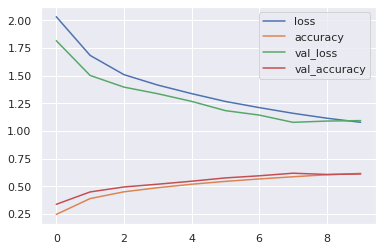


Learning curve 2


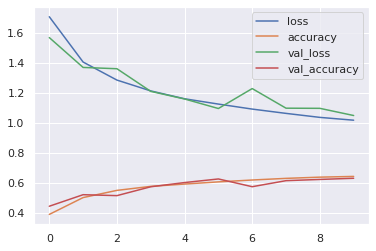


Learning curve 3


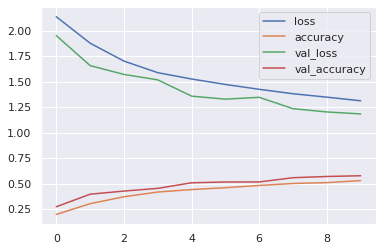


Learning curve 4


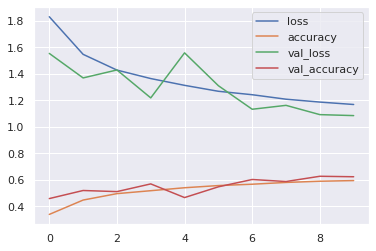


Learning curve 5


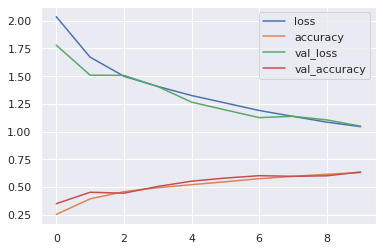


Learning curve 6


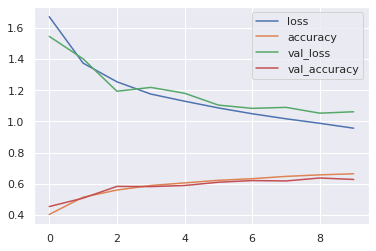


Learning curve 7


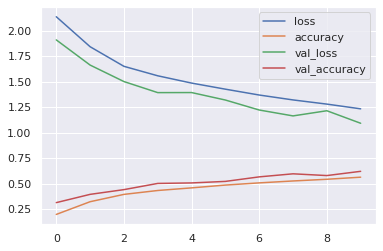


Learning curve 8


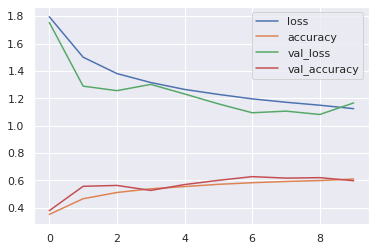

'\npd.DataFrame(history_1.history).plot(figsize=(8, 10))\nplt.grid(True)\nplt.gca().set_ylim(0, 3) # set the vertical range\nplt.show()\n\npd.DataFrame(history_2.history).plot(figsize=(8, 10))\nplt.grid(True)\nplt.show()\n\nprint(\'Learning curves for 8 MLP model experiments\')\nplt.figure(figsize=(10, 8))\nfor i in range(8):\n  learning_curves(hist)\n  ax = plt.subplot(4,2,i+1)\n  ax.set_title("Model ", i)\n\nplt.show()\n\n\nwhile i < 20:\n  if test_y[n] != test_y_pred[n]:\n    ax = plt.subplot(4,5,i+1)\n    plt.imshow(test_X[n])\n    plt.axis(\'off\')\n    ax.set_title(class_names[test_y[n]] +", "+ class_names[test_y_pred[n]])\n    i = i +1\n    n = n +1 \n  else:\n    n = n +1\n\nplt.show()\n\n'

In [95]:
#Plot learning curves
fig_size = (6,4)
if run_cnn_experiments == True:
  print('Learning curves for 8 MLP model experiments')
  learning_curves(history_cnn_1,"1")
  learning_curves(history_cnn_2,"2")
  learning_curves(history_cnn_3,"3")
  learning_curves(history_cnn_4,"4")
  learning_curves(history_cnn_5,"5")
  learning_curves(history_cnn_6,"6")
  learning_curves(history_cnn_7,"7")
  learning_curves(history_cnn_8,"8")
  learning_curves(history_cnn_9,"9")
  learning_curves(history_cnn_10,"10")
  learning_curves(history_cnn_11,"11")
  learning_curves(history_cnn_12,"12")
  learning_curves(history_cnn_13,"13")
  learning_curves(history_cnn_14,"14")
  learning_curves(history_cnn_15,"15")
  learning_curves(history_cnn_16,"16")
else:
  continue

In [96]:
if run_cnn_experiments == True:
  print("model_cnn_1 validation accuracy = ", round(history_cnn_1.history['val_accuracy'][-1],3))
  print("model_cnn_2 validation accuracy = ", round(history_cnn_2.history['val_accuracy'][-1],3))
  print("model_cnn_3 validation accuracy = ", round(history_cnn_3.history['val_accuracy'][-1],3))
  print("model_cnn_4 validation accuracy = ", round(history_cnn_4.history['val_accuracy'][-1],3))
  print("model_cnn_5 validation accuracy = ", round(history_cnn_5.history['val_accuracy'][-1],3))
  print("model_cnn_6 validation accuracy = ", round(history_cnn_6.history['val_accuracy'][-1],3))
  print("model_cnn_7 validation accuracy = ", round(history_cnn_7.history['val_accuracy'][-1],3))
  print("model_cnn_8 validation accuracy = ", round(history_cnn_8.history['val_accuracy'][-1],3))
  print("model_cnn_9 validation accuracy = ", round(history_cnn_9.history['val_accuracy'][-1],3))
  print("model_cnn_10 validation accuracy = ", round(history_cnn_10.history['val_accuracy'][-1],3))
  print("model_cnn_11 validation accuracy = ", round(history_cnn_11.history['val_accuracy'][-1],3))
  print("model_cnn_12 validation accuracy = ", round(history_cnn_12.history['val_accuracy'][-1],3))
  print("model_cnn_13 validation accuracy = ", round(history_cnn_13.history['val_accuracy'][-1],3))
  print("model_cnn_14 validation accuracy = ", round(history_cnn_14.history['val_accuracy'][-1],3))
  print("model_cnn_15 validation accuracy = ", round(history_cnn_15.history['val_accuracy'][-1],3))
  print("model_cnn_16 validation accuracy = ", round(history_cnn_16.history['val_accuracy'][-1],3))
else:
  continue

model_cnn_1 validation accuracy =  0.612
model_cnn_2 validation accuracy =  0.631
model_cnn_3 validation accuracy =  0.577
model_cnn_4 validation accuracy =  0.623
model_cnn_5 validation accuracy =  0.637
model_cnn_6 validation accuracy =  0.628
model_cnn_7 validation accuracy =  0.62
model_cnn_8 validation accuracy =  0.598
model_cnn_9 validation accuracy =  0.65
model_cnn_10 validation accuracy =  0.649
model_cnn_11 validation accuracy =  0.641
model_cnn_12 validation accuracy =  0.642
model_cnn_13 validation accuracy =  0.66
model_cnn_14 validation accuracy =  0.603
model_cnn_15 validation accuracy =  0.662
model_cnn_16 validation accuracy =  0.59


#### Experiment Findings
CNN Model number:
1. ks1, nof1, dr1, af1
2. ks1, nof1, dr1, af2
3. ks1, nof1, dr2, af1
4. ks1, nof1, dr2, af2
5. ks1, nof2, dr1, af1
6. ks1, nof2, dr1, af2
7. ks1, nof2, dr2, af1
8. ks1, nof2, dr2, af2
9. ks2, nof1, dr1, af1
10. ks2, nof1, dr1, af2
11. ks2, nof1, dr2, af1
12. ks2, nof1, dr2, af2
13. ks2, nof2, dr1, af1
14. ks2, nof2, dr1, af2
15. ks2, nof2, dr2, af1
16. ks2, nof2, dr2, af2
```
model_cnn_1 validation accuracy =  0.612
model_cnn_2 validation accuracy =  0.631
model_cnn_3 validation accuracy =  0.577
model_cnn_4 validation accuracy =  0.623
model_cnn_5 validation accuracy =  0.637
model_cnn_6 validation accuracy =  0.628
model_cnn_7 validation accuracy =  0.62
model_cnn_8 validation accuracy =  0.598
model_cnn_9 validation accuracy =  0.65
model_cnn_10 validation accuracy =  0.649
model_cnn_11 validation accuracy =  0.641
model_cnn_12 validation accuracy =  0.642
model_cnn_13 validation accuracy =  0.66
model_cnn_14 validation accuracy =  0.603
model_cnn_15 validation accuracy =  0.662
model_cnn_16 validation accuracy =  0.59
```
From these output final validation accuracies of the 16 CNN variations, we observe that model_cnn_15 produces the highest accuracy of 0.662<br>
Thus, **model 15 has the optimum hyperparameter settings** from our experiments.

- **Kernel Size (KS)**: The size of convolution filter/kernel used. Indicates the size of receptive fields imposed.
  1. ks1: 5x5 with stride of 2, then a 3x3 with stride of 1. We try to reduce the spatial dimension of the image without losing much information in the first layer, followed by a 3x3 in second layer that uses less parameters.
  2. ks2: 3x3 then another 3x3 both with stride of 1. We try to use fewer parameters in computations throughout.
> Both options were comparable. But ks2 seemed to perform better sometimes. It is likely that the low number of convolution layers meant that restricting the spatial dimensions initially (in ks1) would be damaging to the signal.

- **Number of Filters/Kernels (NOF)**:Each convolutional layer is really made up of several feature maps. Each map is made from a filter. We explore how doubling the number of filters would change performance.
  1. nof1: 64
  2. nof2: 128
> Using more filters (nof2) performed better. Makes sense as we have more feature maps that captures more patterns better.

- **Dropout Rate (DR)**: This regularisation technique simply drops some neurons temporarily during each training step. We explore whether dropping out more or less is better in this case.
  1. dr1: 0.1
  2. dr2: 0.3
> Having a lower dropout rate was better in this data. Meaning that less neurons were ignored and could contribute. In other words, dr2 was constricting the model too much.

- **Activation Function (AF)**: We explore two different activation functions. SELU for self-normalisation and ReLU for optimised computation time. We also tie the connection weight initialisation hyperparameter into this experiment.

 1. af1: Normal He initialization with ReLU activation function. 
 2. af2: Normal LeCun initilization with SELU activation function.
> af2 performed better than af1 usually. The self-normalising property of af2 was likely better in this case compared to MLP experiments.


### 3.2 Optimal Settings
Using optimal parameters from experiments<br>

In [100]:
#Ask user if model retraining is required
retrain = input('Retrain the CNN model? (y/n)')
if retrain == 'y':
  #Train optimum CNN model
  history_cnn, model_cnn, cnn_optimizer = cnn_train_model("model_cnn_15", ks2, nof2, dr2, af1, cnn_optimizer)
  model_cnn.save("Joey_Koh_CNN_model.h5") #HDF5 format
else:
  #To restore from file
  model_cnn = keras.models.load_model("Joey_Koh_CNN_model.h5")

#Inspect model
model_cnn.summary() 



Retrain the CNN model? (y/n)y

Training:  model_cnn_15
Epoch 1/10
1407/1407 [==============================] - 8s 6ms/step - loss: 2.0642 - accuracy: 0.2357 - val_loss: 1.8109 - val_accuracy: 0.3740
Epoch 2/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.7397 - accuracy: 0.3681 - val_loss: 1.6961 - val_accuracy: 0.3964
Epoch 3/10
1407/1407 [==============================] - 8s 5ms/step - loss: 1.5527 - accuracy: 0.4376 - val_loss: 1.3604 - val_accuracy: 0.5076
Epoch 4/10
1407/1407 [==============================] - 8s 5ms/step - loss: 1.4381 - accuracy: 0.4804 - val_loss: 1.3744 - val_accuracy: 0.5088
Epoch 5/10
1407/1407 [==============================] - 8s 5ms/step - loss: 1.3447 - accuracy: 0.5192 - val_loss: 1.2138 - val_accuracy: 0.5678
Epoch 6/10
1407/1407 [==============================] - 8s 5ms/step - loss: 1.2679 - accuracy: 0.5459 - val_loss: 1.1397 - val_accuracy: 0.5940
Epoch 7/10
1407/1407 [==============================] - 8s 5ms/step - loss: 1.196

#### CNN Network Architecture
**Layer Settings**
- Input layer: Each input image consists of 32x32 pixels with each pixel represented by 3 RGB values. As the first input layer disregards the pixels' positions, we need to flatten the image into a 1D vector to obtain the number of input neurons required and to feed it in.
> The input layer flattens the image, giving an output of 32x32x3 = 3072

- 2 Hidden layers: Same no. of neurons used for both layers to reduce no. of parameters to tune. Similar performance to pyramid shape configuration.
> First dense hidden layer: It consists of 100 fully connected neurons, so the number of parameters is 3072(inputs) x100(layer neurons) +100 (for bias neurons) = 307300. The number of outputs equals the number of layer neurons of 100.<br>
> Second dense hidden layer: It consists of 100 fully connected neurons, so the number of parameters is 100(inputs) x100(layer neurons) +100 (for bias neurons) = 10100. The number of outputs also is 100.

- Output layer: 10 neurons for the 10 possible classes. Softmax activation function used as this is a multiclass problem with mutually exclusive classes. This ensures outputs are probabilities that sum to 1.
> Output dense layer: With 10 output neurons for the 10 classes the number of parameters is 100(inputs) x10(layer neurons) +10 (for bias neurons) = 1010.<br>

Observe:
- The number of parameters reduce each layer. This is good as we want the network to narrow in some form as we get closer to the final output layer.

#### 3.2.1 Confusion Matrix and Accuracy

This is the confusion matrix for CNN 
 [[732  36  55  16  10  10  10  10  68  53]
 [ 19 789  10  12   0   8   8   5  26 123]
 [ 74   3 554  67  37 128  71  33  16  17]
 [ 22  12  75 410  16 320  67  38  17  23]
 [ 36   4 166 103 339 108 105 113  20   6]
 [ 16   5  62 118  21 690  28  45   8   7]
 [  9   9  57  76  10  58 753   5  13  10]
 [ 24   7  36  37  29 128   3 712   3  21]
 [ 86  62  17  13   0  12   7   3 755  45]
 [ 31 113  11  16   1  10   7  27  29 755]]
Plotting with predicted test dataset labels on horizontal axis, actuals labels on vertical axis


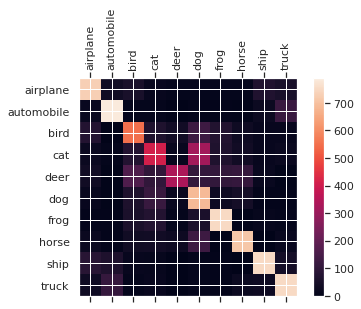

In [98]:
test_y_cnn_pred = np.argmax(model_cnn.predict(test_X), axis=-1) #get predicted class index numbers
#call confusion matrix function
conf_matrix(test_y, test_y_cnn_pred, "CNN")

In [99]:
#plot learning curve
learning_curves(history_cnn, "CNN final")
#Evaluate model accuracy on test set
print("Evaluating CNN model on test set")
model_cnn.evaluate(test_X,test_y) #occurs in batches

TypeError: ignored

### Classification Results of tuned MLP model

Accuracy score on test set: The tuned MLP model obtained a 0.489 accuracy on the test set classification task. Considering a random guess would be 0.1, this result is better than nothing. <br>

Confusion matrix observations: 
- Generally, we have values concentrated on the diagonal. Indicating correct predictions.
- However, we notice some visible non-dark squares outside the diagonal. These incorrect predictions have some noticable patterns in that their images have similar features (eyes, shape, object structure, wheels...etc).
- For vehicles: the following incorrect predictions are common (actual, predicted): (airplane, ship), (truck, automobile), (automobile, ship). Perhaps it is due to airplanes/ships having similar streamlined outlines and colour, truck/automobiles being wheeled vehicles, automobile/ships having windows.
- For animals: bird, cat, deer, dog, frog, horse have many dim squares outside the diagonal indicating incorrect predictions. It is likely due to the common features of legs, eyes, colour, outline. In particular, the cats are often incorrectly classified as dogs. <br>

**Explanation:**
The somewhat unimpressive performance in accuracy is due a few reasons.
- **Constrictions in network architecture** with a limit of 2 hidden layers. MLPs can theoretically model complex problems with a single layer given enough neurons. However, for complex problems like image classification here, deep networks with more layers have a higher parameter efficiency than shallow ones. MLPs are fully connected and aim to model low-level structures in lower hidden layers, continuously building up to higher-level structures in higher layers. When we only have two layers instead of say 5, we have reduced parameter efficiency and lack intermediate layers for intermediate-level structure modelling. We essentially are forced to jump ahead.
- **Low number of epochs**, 10. By restricting the number of passes through the training set, we essentially are implementing early stopping on epoch number 10 regardless of improvement to accuracy or loss function. A better practice is to simply implement early stopping instead and not limit the number of epochs. We observe that the model still has accuracy improvements in the 10th epoch, by stopping the training there, the accuracy cannot improve further even if the model has not converged to a good solution.<br>

**Hyperparameters tuned** This model had the optimum settings found through experiments. However, exploring more hyperparameter settings would likely yield a more optimised model. For example, trying out more activation functions or increasing the number of neurons in a layer.


#### 3.2.2 Correct and Wrong Predictions

In [0]:
# display 20 correct predictions in the test set
print('The first 20 correctly classified images of the test set')
plt.figure(figsize=(10, 8))
i, n = 0, 0
while i < 20:
  if test_y[n] == test_y_cnn_pred[n]:
    ax = plt.subplot(4,5,i+1)
    plt.imshow(test_X[n])
    plt.axis('off')
    ax.set_title(class_names[test_y[n]])
    i = i +1
    n = n +1 
  else:
    n = n +1

plt.show()

# display 20 incorrect predictions in the test set
print('The first 20 incorrectly classified images of the test set. \n Titles are actual class, predicted class respectively')
plt.figure(figsize=(10, 8))
i, n = 0, 0
while i < 20:
  if test_y[n] != test_y_cnn_pred[n]:
    ax = plt.subplot(4,5,i+1)
    plt.imshow(test_X[n])
    plt.axis('off')
    ax.set_title(class_names[test_y[n]] +", "+ class_names[test_y_cnn_pred[n]])
    i = i +1
    n = n +1 
  else:
    n = n +1

plt.show()

**Observations**:
- For correctly classified images, we notice that the model is good at classifying dogs and frogs well, this aligns with our confusion matrix.
- For incorrectly classified images, we notice that the model fails to generalise as well when the images are more open to interpretation. For example the airplane in bottom row could look like a bird, the frog in third row has a similar side-outline to a horse, the airplane in second row looks like a ship surrounded by blue water...etc. This aligns with our conclusions from our confusion matrix.

##4. Comparison of MLP and CNN Models

###Confusion Matrices

In [0]:
#call confusion matrix function
conf_matrix(test_y, test_y_mlp_pred, "MLP")
conf_matrix(test_y, test_y_cnn_pred, "CNN")

**Comparison**:
- 

### Classification Accuracies

In [0]:
#Evaluate model accuracy on test set
print("Evaluating MLP model on test set")
model_mlp.evaluate(test_X,test_y) #occurs in batches
print("\nEvaluating CNN model on test set")
model_cnn.evaluate(test_X,test_y) #occurs in batches


### Network Architecture

In [0]:
model_mlp.summary() 
model_cnn.summary() 

### Training Time

- From training the optimum model, the MLP took and the CNN took